In [1]:
%matplotlib inline

# 去背神器 cntk

![background_removal](../Images/background_removal.jpg)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
import PIL
from PIL import Image
import glob
import threading
import random
import math
import cv2
import datetime
import cntk as C
import numpy as np
from cntk.ops import *
from cntk.layers import *
from cntk.initializer import *
from cntk.logging import *
from cntk.train import *
from cntk.learners import *
from cntk.losses import *
from cntk.device import *

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

![background_removal](../Images/supervise.png)

![background_removal](../Images/SuperviselyPerson.jpg)

In [3]:
imgs_path = glob.glob('../Data/ex05_train/imgs/' + '*.jpg')
mks_path = ['../Data/ex05_train/masks/' + os.path.basename(i)[:-4] + '.png' for i in imgs_path]
print(len(imgs_path))
print(len(mks_path))
print(imgs_path[:5])

5711
5711
['../Data/ex05_train/imgs\\ache-adult-depression-expression-41253.jpg', '../Data/ex05_train/imgs\\active-activity-ball-exercise-41213.jpg', '../Data/ex05_train/imgs\\active-athletic-exercise-female-40974.jpg', '../Data/ex05_train/imgs\\active-cold-female-girl-41371.jpg', '../Data/ex05_train/imgs\\adorable-baby-beautiful-boy-41000.jpg']


In [4]:
#圖片轉向量
def img2array(img: Image):
    arr = np.array(img).astype(np.float32)
    arr=arr.transpose(2, 0, 1) #轉成CHW
    arr=np.ascontiguousarray(arr)
    return arr[::-1] #顏色排序為BGR

#向量轉圖片
def array2img(arr: np.ndarray):
    arr =arr[::-1]#轉成RGB
    sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))#轉成HWC
    img = Image.fromarray(sanitized_img.astype(np.uint8))
    return img



#把圖片並列列印出來
def tile_rgb_images(pred, label, truth, row=3, col=3):
    fig = pylab.gcf()
    fig.set_size_inches(20, 18)

    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()  # is not None:
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        if m % 3 == 0:
            img = array2img(truth[int(m/ 3)]*pred[int(m / 3)]+np.ones((3,256,256))*120*(1-pred[int(m / 3)]))
        elif m % 3 == 1:

            img = array2img(truth[int(m/ 3)]*label[int((m - 1) / 3)]+np.ones((3,256,256))*120*(1-label[int(m / 3)]))
        else:
            img = array2img(truth[int((m - 2) / 3)])
        pylab.imshow(img, interpolation="nearest", animated=True)
        pylab.axis("off")

In [5]:
#數據增強處理函數

#隨機裁切
def random_crop(image,mask):
    min_len=min(image.width,image.height)
    #print(min_len)
    scale=1.
    if min_len<256 or min_len>256*1.5:
        scale=np.random.choice(np.arange(256./min_len,1.5*256./min_len,0.1))
    image=image.resize((int(image.width*scale)+2,int(image.height*scale)+2),Image.ANTIALIAS)
    image=img2array(image)
    mask=mask.resize((int(mask.width*scale)+2,int(mask.height*scale)+2), Image.NEAREST)
    mask=img2array(mask)
    #print('image:{0}'.format(image.shape))
    #print('mask:{0}'.format(mask.shape))
    offset_x=random.choice(range(0,image.shape[2]-256))
    offset_y=random.choice(range(0,image.shape[1]-256))
    #print('offset_x:{0}'.format(offset_x))
    #print('offset_y:{0}'.format(offset_y))
    image=image[:,offset_y:offset_y+256,offset_x:offset_x+256]
    mask=mask[:,offset_y:offset_y+256,offset_x:offset_x+256]
    #print('crop image:{0}'.format(image.shape))
    #print('crop mask:{0}'.format(mask.shape))
    return image,mask[0,:,:]
        
#隨機加入標準常態分配的噪聲
def add_noise(image):
    noise=np.random.standard_normal(image.shape)*np.random.choice(np.arange(-15,15))
    image=np.clip(image+noise,0,255)
    return image

#調整明暗
def adjust_gamma(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    cv2.LUT(image.astype(np.uint8), table)
    image = image.transpose([2, 0, 1])
    return image

#模糊
def adjust_blur(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    image=cv2.blur(image, (3, 3))
    image = image.transpose([2, 0, 1])
    return image



In [6]:
idx=0
idxs=np.arange(len(imgs_path))
np.random.shuffle(idxs)

def get_next_minibatch(minibatch_size=8, is_train=True):
    global idx,idxs
    features=[]
    masks=[]
    sizes=[]
    while len(features)<minibatch_size:
        im,mk=random_crop(Image.open(imgs_path[idxs[idx]]),Image.open(mks_path[idxs[idx]]))
        
        #print(im.shape),print(mk.shape)
        if is_train:
            if random.randint(0,10)%3==0:
                im=add_noise(im)

            if random.randint(0,10)%5<=1: #水平翻轉
                im=im[:,:, ::-1]
                mk=mk[:, ::-1]

            if random.randint(0,10)%3==0:
                im=adjust_blur(im)
                
            if random.randint(0,10)%2==0: #明暗
                gamma=np.random.choice(np.arange(0.6, 1.4, 0.05))
                img=adjust_gamma(im,gamma)
            
        
        mk[mk>0]=1
        mk=np.expand_dims(mk,0)
        decode_mk=np.concatenate([1-mk,mk],axis=0)
        #print(decode_mk.shape)
        

        features.append(im/255.0)
        masks.append(decode_mk)
        idx+=1
        if idx>=len(imgs_path)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(masks).astype(np.float32)
                                
features_x,mask_y=get_next_minibatch(2)
print(features_x.shape)
print(mask_y.shape)

(2, 3, 256, 256)
(2, 2, 256, 256)


![background_removal](../Images/deeplabv3.jpg)

![background_removal](../Images/aspp.jpg)

In [7]:
def conv_bn(input, filter_size, num_filters, strides=(1, 1), init=C.he_normal(), bias=False):
    c = Convolution(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides, bias=bias)(input)
    r = BatchNormalization(map_rank=1)(c)
    return r

def conv_bn_relu(input, filter_size, num_filters, strides=(1, 1), init=C.he_normal(), bias=False):
    r = conv_bn(input, filter_size, num_filters, strides, init, bias=bias)
    return relu(r)

#涉及訓練參數upsampling(轉置卷積)
def upsampling(x):
    x=ConvolutionTranspose2D((3,3),x.shape[0], strides=(2, 2),pad=True,output_shape=(x.shape[1]*2,x.shape[2]*2))(x)
    return x

#不涉及訓練參數upsampling
def upsampling_resize(x):
    xr = C.reshape(x, (x.shape[0], x.shape[1], 1, x.shape[2], 1))
    xx = C.splice(xr, xr, axis=-1) # axis=-1 refers to the last axis
    xy = C.splice(xx, xx, axis=-3) # axis=-3 refers to the middle axis
    r = C.reshape(xy, (x.shape[0], x.shape[1] * 2, x.shape[2] * 2))
    return r

def aspp(input):
    image_features=AveragePooling((64//8,64//8),(64//8,64//8),pad=True)(input)
    image_features=conv_bn_relu(image_features,(1,1), 256,bias=True)
    #print(image_features.shape)
    image_features=upsampling_resize(upsampling_resize(upsampling_resize(image_features)))
    #print(image_features.shape)
    
   
    atrous_block1  = conv_bn_relu(input,(1,1), 256,bias=False)
    #print(atrous_block1.shape)
    atrous_block6  = Convolution((3,3), 256, activation=relu,pad=True, strides=1,bias=False,dilation=6,name='atrous_block6')(input)
    #print(atrous_block6.shape)
    atrous_block12 = Convolution((3,3), 256, activation=relu,pad=True, strides=1,bias=False,dilation=12,name='atrous_block12')(input)
    #print(atrous_block12.shape)
    atrous_block18 = Convolution((3,3), 256, activation=relu,pad=True, strides=1,bias=False,dilation=18,name='atrous_block18')(input)
    #print(atrous_block18.shape)
    net=splice(image_features,atrous_block1,atrous_block6,atrous_block12,atrous_block18,axis=0)
    net=conv_bn_relu(net,(1,1), 256)
    net=dropout(net,0.1)
    return net

In [8]:


#
# ResNet單元結構
#
def resnet_basic(input, num_filters):
    c1 = conv_bn_relu(input, (3, 3), num_filters)
    c2 = conv_bn(c1, (3, 3), num_filters)
    p = c2 + input
    return relu(p)

def resnet_basic_inc(input, num_filters, strides=(2, 2)):
    c1 = conv_bn_relu(input, (3, 3), num_filters, strides)
    c2 = conv_bn(c1, (3, 3), num_filters)
    s = conv_bn(input, (1, 1), num_filters, strides) # Shortcut
    p = c2 + s
    return relu(p)

def resnet_basic_stack(input, num_stack_layers, num_filters): 
    assert(num_stack_layers >= 0)
    l = input
    for _ in range(num_stack_layers):
        l = resnet_basic(l, num_filters)
    return l


#根據指定stack數建構resnet20
#如果num_stack_layers=5，則為resnet 50
def resnet_backbond(input, num_stack_layers=3):
    conv = conv_bn_relu(input, (3, 3), 16)
    r1 = resnet_basic_stack(conv, num_stack_layers, 16)
    r2_1 = resnet_basic_inc(r1, 64)
    r2_2 = resnet_basic_stack(r2_1, num_stack_layers-1, 64)
    r3_1 = resnet_basic_inc(r2_2, 256)
    r3_2 = resnet_basic_stack(r3_1, num_stack_layers-1,256)
    return r3_2


In [9]:
def deeplabv3(input):
    x=resnet_backbond(input,3)
    #print(x.shape)
    x=aspp(x)
    x=conv_bn_relu(x,(3,3),256)
    x=conv_bn_relu(x,(3,3),256)
    x=upsampling_resize(x)
    x=upsampling(x)#轉置卷積上採樣
    #print(x.shape)
    x=Convolution((1,1),2,activation=sigmoid)(x)
    return x
    

In [10]:
minibatch_size =4
num_epochs = 3
learning_rate = 0.0000125  # 學習速率

input_var = C.input_variable((3, 256, 256), dtype=np.float32)
mask_var = C.input_variable((2, 256, 256), dtype=np.float32)

z=deeplabv3(input_var)
if os.path.exists('Models/deeplabv3_cntk.cnn'):
    model = Function.load('Models/deeplabv3_cntk.cnn')
    z = model(input_var)
    print('載入原有模型累積訓練')

#為了要計算softmax以及二維交叉商，故意先reshape成一維
z1 = reshape(z, (2, -1))
mask_var1 = reshape(mask_var, (2,-1))

#p是產生預測值  t是目標值
p = squeeze(argmax(z1 , 0))
t = squeeze(argmax(mask_var1, 0))

#i1為交集 u1為聯集
i1 = reduce_sum(equal(t, p) * greater(t, 0))
u1 = reduce_sum(greater(p+t, 0)) + 1e-10
u2 = reduce_sum(greater(t, 0)) + 1e-10

iou = i1 / u1
iot = i1 / u2
iou_loss = C.negate(C.log(iou+ 1e-10))


# 定義進行訓練的損失函數以及錯誤率計算
#損失函數為2d交叉商+iou loss
loss =reduce_mean(cross_entropy_with_softmax(z1,mask_var1,0))
errs = iou
# 列印模型參數
log_number_of_parameters(z)


progress_printer = ProgressPrinter(freq=50, tag='Training', num_epochs=num_epochs)
learner = adam(z.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, num_epochs),
                       momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(0.95)],epoch_size=num_epochs),
                       l1_regularization_weight=0.0001, l2_regularization_weight=1e-5)

trainer = Trainer(z, (loss, errs), learner, progress_printer)

載入原有模型累積訓練
Training 7327762 parameters in 86 parameter tensors.


In [11]:
for epoch_count in range(num_epochs):
    mbs = 0
    rows = 0
    while mbs <500:
        try:
            raw_features, raw_masks = get_next_minibatch(minibatch_size)
            trainer.train_minibatch({input_var: raw_features, mask_var: raw_masks})
            #每100次存一次檔
            if (mbs+1) % 100 == 0 :
                z.save("Models/deeplabv3_cntk.cnn")
            if (mbs+1) % 100 == 0 :
                learning_rate*=0.75
            if (mbs+1) % 500 == 0 :
                print('learning_rate:{0}'.format(learning_rate))
        except Exception as e:
            print(e)
        mbs += 1
    trainer.summarize_training_progress()
    
    z.save("Models/deeplabv3_cntk.cnn")
    

Learning rate per 1 samples: 1.25e-05
 Minibatch[   1-  50]: loss = 0.500220 * 200, metric = 55.08% * 200;
 Minibatch[  51- 100]: loss = 0.484586 * 200, metric = 54.86% * 200;
 Minibatch[ 101- 150]: loss = 0.491998 * 200, metric = 54.18% * 200;
 Minibatch[ 151- 200]: loss = 0.487694 * 200, metric = 52.36% * 200;
 Minibatch[ 201- 250]: loss = 0.491209 * 200, metric = 53.15% * 200;
 Minibatch[ 251- 300]: loss = 0.494435 * 200, metric = 54.99% * 200;
 Minibatch[ 301- 350]: loss = 0.482741 * 200, metric = 54.60% * 200;
 Minibatch[ 351- 400]: loss = 0.481003 * 200, metric = 56.58% * 200;
 Minibatch[ 401- 450]: loss = 0.479998 * 200, metric = 55.65% * 200;
 Minibatch[ 451- 500]: loss = 0.472224 * 200, metric = 55.32% * 200;
learning_rate:2.96630859375e-06
Finished Epoch[1 of 3]: [Training] loss = 0.486611 * 2000, metric = 54.68% * 2000 361.351s (  5.5 samples/s);
 Minibatch[   1-  50]: loss = 0.479297 * 200, metric = 55.87% * 200;
 Minibatch[  51- 100]: loss = 0.471743 * 200, metric = 56.98%

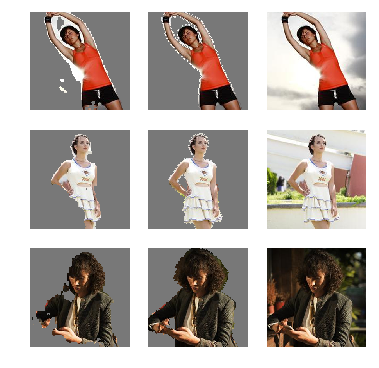

In [16]:
raw_features, raw_masks = get_next_minibatch(3,False)
e = z(raw_features)
e1 = np.argmax(e,1)
m1 = np.argmax(raw_masks,1)
tile_rgb_images(e1, m1, raw_features*255., row=3, col=3)